# Capstone Project: Detection of Bus Number in Bus Panel

## Contents:
- [Problem Statement](#Problem-Statement)
- [Dataset](#Dataset)
- [Setup](#Setup)
- [Generate frames from video](#Generate-frames-from-video)
- [Image Labelling](#Image-Labelling)
- [Correctly Format Custom Dataset](#Correctly-Format-Custom-Dataset)
- [Next Steps](#Next-Steps)

## Problem Statement
Mobility and orientation are the biggest challenges for people with visual impairments. This includes walking, taking public transportation, or even getting a ride on buses. Developing assistive technologies to help them navigate outdoor environments could potentially improve their quality of life. Since public transportation, such as buses, is a main tool for people with visual impairments to navigate outdoor, this project aims to create a proof of concept (POC) that can help people with visual impairment to determine if it’s the right bus they need through Optical Character Recognition (OCR) for the text on the bus.

## Dataset

The dataset that we'll be using for this project are YouTube videos of public buses arriving at a bus stop in Singapore.
- [Video1](https://www.youtube.com/watch?v=gvw2IUFpjvQ&t=2s)
- [Video2](https://www.youtube.com/watch?v=FoJRvKlVTEA&t=332s)

We'll create a custom class to extract individual frames from the videos, so that we're able to train a custom object detector to detect the bus panel and use OCR to read the bus number in bus panel.

## Setup
All libraries used should be added here.

In [1]:
# import libraries
from PIL import Image
import cv2
import os
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
import shutil
from loguru import logger
import yaml

In [2]:
# set relative paths
video_path = '../videos'
image_path = '../images'
annotations_path = '../annotations'
data_path = '../data'
os.makedirs(image_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)

## Generate frames from video
Let's create a class called `ExtractVideoFrames` to extract individual frames from a video file and save them as images.

In [3]:
class ExtractVideoFrames():
    '''
    Class to extract individual frames from a video file and save them as images.
    '''
    def __init__(self, video_path):
        self.video_path = video_path
        self.vid_cap = cv2.VideoCapture(video_path)
        # extract some characteristics of the video
        self.n_frames = int(self.vid_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.fps = int(self.vid_cap.get(cv2.CAP_PROP_FPS))
        
    def get_total_frame_number(self):
        video = self.video_path
        # get total number of frames of the video
        total = self.n_frames
        logger.info(f'Total number of frames of {video}: {total}')
        
    def get_fps(self):
        video = self.video_path
        # get total frames per second (FPS) of the video
        fps = self.fps
        logger.info(f'Total frames per second of {video}: {fps}')
        
    def get_video_duration(self):
        video = self.video_path
        duration = self.n_frames/self.fps
        logger.info(f'Duration of {video}: {datetime.timedelta(seconds=duration)}')
        
    def get_n_images(self, interval):
        video = self.video_path
        n_images = math.floor(self.n_frames / interval) + 1
        logger.info(f'Extracting every {interval} frame from {video} would generate {n_images} images into the output directory.')
        
    def extract_frames(self, interval, image_name, output_directory):
        video = self.video_path
        try:
            if not os.path.exists(output_directory):
                os.makedirs(output_directory)
                logger.info(f'Created the following directory: {output_directory}')
                
        except OSError:
            logger.error('Error creating directory')
        
        if not self.vid_cap.isOpened():
            self.vid_cap = cv2.VideoCapture(self.video_path)
            
        frame_count = 0
        image_count = 0

        while self.vid_cap.isOpened():
            ret, frame = self.vid_cap.read()
            
            if (ret != True):
                break
                
            if (frame_count % interval == 0):
                # write frame to JPEG file (eg. image_1.jpg, image_2.jpg, ...)
                cv2.imwrite(output_directory + "/" + image_name + "_%d.jpg" % image_count, frame)
                image_count += 1
            
            frame_count += 1
            
        # release video pointer
        self.vid_cap.release()
        logger.info(f'Completed extracting frames from {video}!')

In [4]:
output = {}

# instantiate the object of ExtractVideoFrames class
for f in os.listdir(video_path):
    output[f] = ExtractVideoFrames(video_path + '/' + f'{f}')
    
evf1 = output['video1.mp4']
evf2 = output['video2.mp4']

Let's investigate the total frames per second of our videos:

In [5]:
evf1.get_fps()
evf2.get_fps()

2021-08-31 20:34:07.672 | INFO     | __main__:get_fps:22 - Total frames per second of ../videos/video1.mp4: 29
2021-08-31 20:34:07.677 | INFO     | __main__:get_fps:22 - Total frames per second of ../videos/video2.mp4: 29


To capture image from both videos at every second, we will have to extract every 29th frame. To calculate the number of images that will be extracted, we'll run the following lines of codes:

In [6]:
evf1.get_n_images(29)
evf2.get_n_images(29)

2021-08-31 20:34:07.687 | INFO     | __main__:get_n_images:32 - Extracting every 29 frame from ../videos/video1.mp4 would generate 1110 images into the output directory.
2021-08-31 20:34:07.688 | INFO     | __main__:get_n_images:32 - Extracting every 29 frame from ../videos/video2.mp4 would generate 1324 images into the output directory.


Let's proceed to extract the images:

In [7]:
%%time 
evf1.extract_frames(interval = 29, image_name = 'bus_video1', output_directory= image_path)
evf2.extract_frames(interval = 29, image_name = 'bus_video2', output_directory= image_path)

2021-08-31 20:37:23.129 | INFO     | __main__:extract_frames:65 - Completed extracting frames from ../videos/video1.mp4!
2021-08-31 20:41:11.016 | INFO     | __main__:extract_frames:65 - Completed extracting frames from ../videos/video2.mp4!


Wall time: 7min 3s


### Display sample image

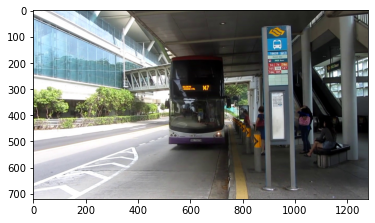

In [8]:
image = Image.open(image_path + '/bus_video1_136.jpg')
plt.imshow(image);

In [9]:
print("Format:", image.format)
print("Size:", image.size)
print("Mode:", image.mode)

Format: JPEG
Size: (1280, 720)
Mode: RGB


## Image Labelling
Next, we need to label the target object (bus panel) by drawing bounding boxes in images. For this task, we will be using [CVAT](https://cvat.org/).  CVAT is a free open source labeling tool which we can utilise to make our annotations more efficient.

### Launch New CVAT Task
Once into the CVAT website, we can launch a new task and drag our images in for labelling. We'll specify the class label of the object that we would like to detect, in this case it will be `bus panel`. 

Once our data is uploaded, we will see a task page:

[<img src="../assets/cvat task page.png" width="750"/>](../assets/cvat%20task%20page.png)
<center><i>CVAT Task Page</i></center>


### Drawing Annotations in CVAT
Now we are ready to draw bounding boxes around the bus panels for our images.

[<img src="../assets/sample image in labelling task.png" width="750"/>](../assets/sample%20image%20in%20labelling%20task.png)
<center><i>Photo of an image in the labeling task</i></center>

We'll only be drawing bounding boxes on bus panels for buses that are arriving at the bus stop. The annotations are manually reviewed to ensure that the bus panels are properly labelled in all our images. 


### Exporting Annotations From CVAT
Great, now we have a labeled dataset. The saved annotations are exported to YOLO format. This format contains one text file per image (containing the bounding box annotations) . However, note that if we did not annotate any bus panel (simply because it does not exists) in the image, CVAT will still export the annotation as an empty text file. Hence, we'll need to check that the text file exists and is not empty.

### Check that the annotation exists and is not empty

In [10]:
def get_annotated_filenames(path):
    # create an empty list to store the filenames
    annotations = []
    for f in os.listdir(path):
        try:
            # if the file is a text file and is not empty:
            if f[-4:] == '.txt' and os.path.getsize(path + '/' + f) > 0:
                # non empty text file exists
                # get file name
                annotations.append(f[:-4])
            else:
                continue
        except OSError as e:
            # file does not exists or is non accessible
            logger.error('{} does not exists or is non accessible'.format(f))
    logger.info('{} label(s)'.format(len(annotations)))
    return annotations

In [11]:
# note: annotations_path stores annotations exported from CVAT
annotations = get_annotated_filenames(annotations_path)

2021-08-31 20:41:11.877 | INFO     | __main__:get_annotated_filenames:16 - 500 label(s)


## Correctly Format Custom Dataset
Let's create a helper function that helps us to correct the formatting of our custom dataset and split them into train, validation, and test set.

In [12]:
# split into train, test, validation
# 70% of our dataset to the training set
# hold out 20% of our dataset for the validation set
# allocate 10% of our dataset to the test set

def create_dataset(val_ratio, test_ratio, image_path, annotations_path, dest_path, filenames):

    # create folder structure:
    # dest_path (destination path)
    # ├── train
    # │   ├── images
    # │   └── labels
    # ├── test
    # │   ├── images
    # │   └── labels
    # └── val
    #     ├── images
    #     └── labels
    
    # dest_path/train/images 
    train_images_path = dest_path + '/train/images' 
    os.makedirs(train_images_path, exist_ok=True)
    
    # dest_path/train/labels
    train_labels_path = dest_path + '/train/labels' 
    os.makedirs(train_labels_path, exist_ok=True)

    # dest_path/test/images 
    test_images_path = dest_path + '/test/images' 
    os.makedirs(test_images_path, exist_ok=True)
    
    # dest_path/test/labels
    test_labels_path = dest_path + '/test/labels' 
    os.makedirs(test_labels_path, exist_ok=True)
    
    # dest_path/val/images 
    val_images_path = dest_path + '/val/images' 
    os.makedirs(val_images_path, exist_ok=True)
    
    # dest_path/val/labels
    val_labels_path = dest_path + '/val/labels' 
    os.makedirs(val_labels_path, exist_ok=True)

    # shuffle annotations
    # set seed to re-produce the same output
    random.seed(42)
    random.shuffle(filenames)
    train_filenames, val_filenames, test_filenames = np.split(np.array(filenames),
                                                          [int(len(filenames)* (1 - (val_ratio + test_ratio))), 
                                                           int(len(filenames)* (1 - test_ratio))])
    
    logger.info('Total images: {}'.format(len(annotations)))
    logger.info('Training: {}'.format(len(train_filenames)))
    logger.info('Validation: {}'.format(len(val_filenames)))
    logger.info('Testing: {}'.format(len(test_filenames)))
    
    # copy-pasting images & txt files into train dir
    logger.info('Moving training images and labels..')
    for name in tqdm(train_filenames):
        shutil.copy(image_path + '/' + name + '.jpg', train_images_path)
        shutil.copy(annotations_path + '/' + name + '.txt', train_labels_path)
                
    # copy-pasting images & txt files into val dir    
    logger.info('Moving validation images and labels..')
    for name in tqdm(val_filenames):
        shutil.copy(image_path + '/' + name + '.jpg', val_images_path)
        shutil.copy(annotations_path + '/' + name + '.txt', val_labels_path)

    # copy-pasting images & txt files into test dir 
    logger.info('Moving test images and labels..')
    for name in tqdm(test_filenames):
        shutil.copy(image_path + '/' + name + '.jpg', test_images_path)
        shutil.copy(annotations_path + '/' + name + '.txt', test_labels_path)
                
    logger.info('Task Completed..')

In [13]:
create_dataset(val_ratio = 0.2, test_ratio = 0.1, image_path = image_path, annotations_path = annotations_path, dest_path = data_path, filenames = annotations)

2021-08-31 20:41:11.920 | INFO     | __main__:create_dataset:52 - Total images: 500
2021-08-31 20:41:11.922 | INFO     | __main__:create_dataset:53 - Training: 350
2021-08-31 20:41:11.923 | INFO     | __main__:create_dataset:54 - Validation: 100
2021-08-31 20:41:11.925 | INFO     | __main__:create_dataset:55 - Testing: 50
2021-08-31 20:41:11.926 | INFO     | __main__:create_dataset:58 - Moving training images and labels..
100%|███████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 204.34it/s]
2021-08-31 20:41:13.650 | INFO     | __main__:create_dataset:64 - Moving validation images and labels..
100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 190.81it/s]
2021-08-31 20:41:14.178 | INFO     | __main__:create_dataset:70 - Moving test images and labels..
100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 194.27it/s]
2021-08-31 2

### Create a YAML configuration file for our dataset

In [14]:
data = {
    "train": "../train/images",
    "val": "../val/images",
    "nc": 1,
    "names": ['bus panel']
}

In [15]:
file = open("../data/data.yaml", "w")
yaml.dump(data, file)
file.close()

In [16]:
# zip the newly formated dataset so that we can import it to google colab for model training
shutil.make_archive('../data', 'zip', data_path)

'C:\\Users\\Wenna\\OneDrive\\Desktop\\GA DSI\\projects\\capstone\\data.zip'

## Next Steps
We'll proceed to train YOLOv5 for custom object detection to detect the bus panels. This will be done using Google Colab.